<a href="https://colab.research.google.com/github/mahhhdy/thesis/blob/main/Classification_with_svm_sklearn_dencity_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


this post has been used </br>
https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/1829ad5c8b3ece7b0e9c16fd76cf2550142683b2/StockPricePrediction.py#L11

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout
from keras.layers import LSTM , SimpleRNN
from keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error
from google.colab import drive
from google.colab import files
# from keras.layers.normalization import batch_normalization

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

np.random.seed(7)

########## import dataset ##########
drive.mount('/content/drive')
path='/content/drive/MyDrive/DataSets/BTCPrediction/15XAUUSD.csv'
dataset = pd.read_csv(path,usecols=[1,2,3,4])
# dataset = pd.read_csv(path)

########## import Guass rank scaler ##########
!cp /content/drive/MyDrive/Colab\ Notebooks/Thesis/gauss_rank_scaler.py /content/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
dataset = dataset.rename({'Time':'Date','|PD|':'PD'},axis=1)

In [154]:
dataset = dataset.reindex(index = dataset.index[::-1])

In [155]:
obs = np.arange(1, len(dataset) + 1, 1)
obs

array([   1,    2,    3, ..., 1998, 1999, 2000])

In [156]:
dataset['Average'] = dataset[['Open','Close','Low','High']].mean(axis=1)
dataset

,Open,High,Low,Close,Average
1999,1969.85,1969.89,1968.79,1969.83,1969.5900
1998,1969.83,1970.20,1968.71,1969.82,1969.6400
1997,1969.82,1970.53,1969.43,1969.59,1969.8425
1996,1969.62,1969.63,1967.69,1968.26,1968.8000
1995,1968.26,1969.20,1967.60,1969.19,1968.5625
...,...,...,...,...,...
4,1807.78,1809.65,1807.64,1809.45,1808.6300
3,1809.45,1810.18,1808.86,1809.46,1809.4875
2,1809.43,1810.43,1809.42,1810.31,1809.8975
1,1810.26,1811.15,1810.07,1811.13,1810.6525


In [157]:
dataset['State'] =( dataset['Close'] > dataset['Open']).astype(int)
dataset

,Open,High,Low,Close,Average,State
1999,1969.85,1969.89,1968.79,1969.83,1969.5900,0
1998,1969.83,1970.20,1968.71,1969.82,1969.6400,0
1997,1969.82,1970.53,1969.43,1969.59,1969.8425,0
1996,1969.62,1969.63,1967.69,1968.26,1968.8000,0
1995,1968.26,1969.20,1967.60,1969.19,1968.5625,1
...,...,...,...,...,...,...
4,1807.78,1809.65,1807.64,1809.45,1808.6300,1
3,1809.45,1810.18,1808.86,1809.46,1809.4875,1
2,1809.43,1810.43,1809.42,1810.31,1809.8975,1
1,1810.26,1811.15,1810.07,1811.13,1810.6525,1


In [158]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset[['Average']]
# HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['State']]

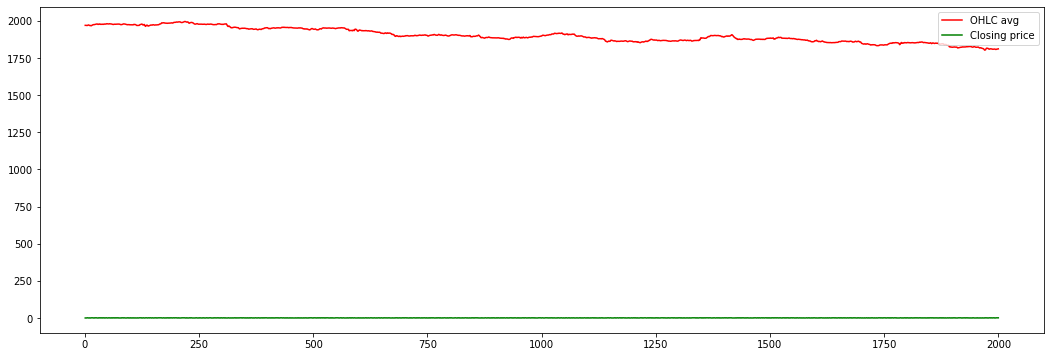

In [160]:
plt.figure(figsize=(18,6))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [161]:
# from gauss_rank_scaler import GaussRankScaler
# scaler = GaussRankScaler()

In [162]:
from sklearn.preprocessing import MinMaxScaler

In [163]:
OHLC_avg = np.reshape(OHLC_avg.values , (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [164]:
# print(OHLC_avg)

In [165]:
# OHLC_avg.shape

In [166]:
train_OHLC = int(len(OHLC_avg) * 0.8)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [167]:
train_OHLC.shape , test_OHLC.shape , train_OHLC.shape[0] + test_OHLC.shape[0]

((1600, 1), (400, 1), 2000)

In [172]:
train_OHLC

array([[0.86443931],
       [0.86469871],
       [0.86574927],
       ...,
       [0.32132759],
       [0.3306529 ],
       [0.32415502]])

In [168]:
import tensorflow as tf

In [169]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [72]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [73]:
trainX.shape , testX.shape , trainX.shape[0] + testX.shape[0] , '----' , trainY.shape , testY.shape , trainY.shape[0] + testY.shape[0]

((1598, 1), (398, 1), 1996, '----', (1598,), (398,), 1996)

In [74]:
train_OHLC[780:787,:]

array([[0.52775544],
       [0.52047936],
       [0.51676999],
       [0.51551192],
       [0.51025914],
       [0.51182849],
       [0.51352753]])

In [75]:
# trainX

In [76]:
# testX

In [77]:
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
step_size = 1

In [78]:
# # LSTM MODEL
# model = Sequential()
# model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
# model.add(LSTM(16))
# model.add(Dense(1))
# model.add(Activation('linear'))

# # MODEL COMPILING AND TRAINING
# model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
# model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

In [124]:
trainY

array([[1969.64  ],
       [1969.8425],
       [1968.8   ],
       ...,
       [1861.8375],
       [1864.9025],
       [1866.7   ]])

In [122]:
batchSize=32

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (trainX.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.add(Activation('sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.fit(trainX, trainY, epochs = 100, batch_size = batchSize, validation_split = 0.2)

Epoch 1/100
40/40 [==============================] - 9s 56ms/step - loss: -258.0233 - val_loss: -796.6382
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: -6695.0186 - val_loss: -15829.8652
Epoch 3/100
40/40 [==============================] - 0s 8ms/step - loss: -22533.7559 - val_loss: -25141.8828
Epoch 4/100
40/40 [==============================] - 0s 8ms/step - loss: -28207.5625 - val_loss: -29575.3008
Epoch 5/100
40/40 [==============================] - 0s 8ms/step - loss: -32262.1191 - val_loss: -33412.2734
Epoch 6/100
40/40 [==============================] - 0s 7ms/step - loss: -36083.7109 - val_loss: -36995.6953
Epoch 7/100
40/40 [==============================] - 0s 8ms/step - loss: -39605.0625 - val_loss: -40427.9922
Epoch 8/100
40/40 [==============================] - 0s 8ms/step - loss: -43052.7695 - val_loss: -43762.2930
Epoch 9/100
40/40 [==============================] - 0s 8ms/step - loss: -46489.9922 - val_loss: -47034.0742
Epoch 10/100
40/40 [===

In [80]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [81]:
trainPredict.shape , trainY.shape

((1598, 1), (1598,))

In [82]:
# trainY[:5]

In [83]:
# DE-NORMALIZING FOR PLOTTING

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [84]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.90


In [85]:


# df = pd.DataFrame([trainY[0], columns = ['Name'])

In [86]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 10.01


In [87]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [88]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [89]:
trainPredict.shape , testPredict.shape

((1598, 1), (398, 1))

In [90]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

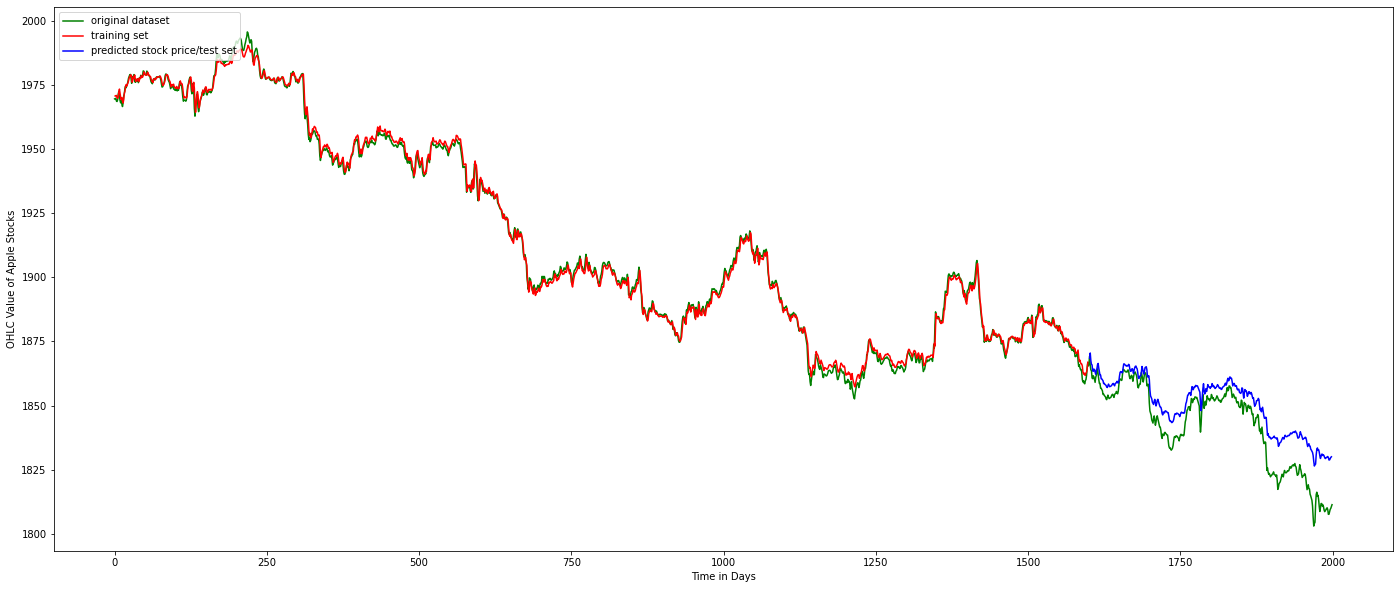

In [91]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(24, 10))
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [92]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
# print "Last Day Value:", np.asscalar(last_val)
# print "Next Day Value:", np.asscalar(last_val*next_val)
# print np.append(last_val, next_val)

print("Last Day Value:", last_val)
print("Next Day Value:", last_val*next_val)
# print(np.append(last_val, next_val)

Last Day Value: [1829.9944]
Next Day Value: [[1780.2792]]


In [93]:
df2 = pd.DataFrame()

In [94]:
trainY = trainY.T
testY = testY.T

In [95]:
perdictCol = np.vstack((trainPredict , testPredict))  
dataCol = np.vstack((trainY , testY))  

perdictCol  = perdictCol.reshape(-1)
dataCol  = dataCol.reshape(-1)

perdictCol.shape , dataCol.shape

((1996,), (1996,))

In [96]:
my_array = np.array([perdictCol,dataCol]).T

In [97]:
df2 = pd.DataFrame(my_array, columns = ['perdictCol','dataCol'])
df2['diff'] = df2['perdictCol'] - df2['dataCol']

In [98]:
df2.tail()

,perdictCol,dataCol,diff
1991,1828.747681,1807.5975,21.150181
1992,1828.776489,1808.6300,20.146489
1993,1829.320312,1809.4875,19.832813
1994,1829.775635,1809.8975,19.878135
1995,1829.994385,1810.6525,19.341885


In [99]:
(df2['diff']>2).sum() + (df2['diff'] < -2).sum() 

807

In [100]:
distance, warp_path = fastdtw(df2['perdictCol'],df2['dataCol'], dist=euclidean)

In [101]:
distance

3080.2871923828325

DTW Plot

In [102]:
# fig, ax = plt.subplots(figsize=(16, 12))

# # Remove the border and axes ticks
# fig.patch.set_visible(False)
# ax.axis('off')

# for [map_x, map_y] in warp_path:
#     ax.plot([map_x, map_y], [df2['perdictCol'][map_x], df2['dataCol'][map_y]], '-k')

# ax.plot(df2['perdictCol'], color='blue', marker='o', markersize=10, linewidth=5)
# ax.plot(df2['dataCol'], color='red', marker='o', markersize=10, linewidth=5)
# ax.tick_params(axis="both", which="major", labelsize=18)

# # fig.savefig("ex2_dtw_distance.png", **savefig_options)

# KMeans on OHLC_avg for clusetering

In [103]:
from sklearn.cluster import KMeans

In [104]:
kmeans = KMeans(4)
kmeans.fit(OHLC_avg)

KMeans(n_clusters=4)

In [105]:
identified_clusters = kmeans.fit_predict(OHLC_avg)
identified_clusters

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [106]:
(identified_clusters==0).sum()

187

In [107]:
OHLC_avg.shape

(2000, 1)

# sklearn density


In [108]:
OHLC_avg = OHLC_avg.flatten()
OHLC_avg.shape

(2000,)

In [109]:
from sklearn.neighbors import KernelDensity

In [110]:
y_d = np.linspace(OHLC_avg.min(), OHLC_avg.max(), 2000)

(1802.9650000000001, 1995.72)

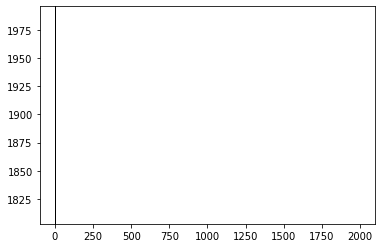

In [111]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit([OHLC_avg])

# score_samples returns the log of the probability density
logprob = kde.score_samples([OHLC_avg])

plt.fill_between(y_d, np.exp(logprob), alpha=0.5)
plt.plot(np.full_like(OHLC_avg, -0.01), OHLC_avg , '|k', markeredgewidth=1)
plt.ylim(OHLC_avg.min(), OHLC_avg.max())


In [112]:
x_d = np.linspace(OHLC_avg.min(), OHLC_avg.max(), 2000)

(1802.9650000000001, 1995.72)

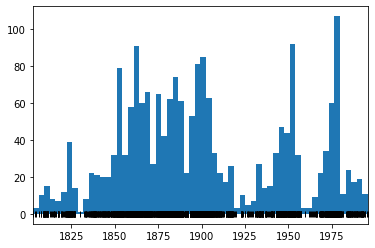

In [113]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit([OHLC_avg])

# score_samples returns the log of the probability density
logprob = kde.score_samples([OHLC_avg])

plt.fill_between(x_d,np.exp(logprob) , alpha=0.5)
plt.plot(OHLC_avg, np.full_like(OHLC_avg, -0.01), '|k', markeredgewidth=1)
plt.hist(OHLC_avg, bins=60)
plt.xlim(OHLC_avg.min(), OHLC_avg.max())

In [114]:
# def make_data(N, f=0.3, rseed=1):
#     rand = np.random.RandomState(rseed)
#     x = rand.randn(N)
#     x[int(f * N):] += 5
#     return x

x = OHLC_avg

In [115]:
from scipy.stats import norm
x_d = np.linspace(OHLC_avg.min(), OHLC_avg.max(), 2000)
x_ticks = np.around(np.linspace(OHLC_avg.min(), OHLC_avg.max(), 20),4)

In [116]:
x_ticks

array([1802.965, 1813.11 , 1823.255, 1833.4  , 1843.545, 1853.69 ,
       1863.835, 1873.98 , 1884.125, 1894.27 , 1904.415, 1914.56 ,
       1924.705, 1934.85 , 1944.995, 1955.14 , 1965.285, 1975.43 ,
       1985.575, 1995.72 ])

In [117]:
from matplotlib.ticker import FormatStrFormatter


(array([1802.965, 1813.11 , 1823.255, 1833.4  , 1843.545, 1853.69 ,
        1863.835, 1873.98 , 1884.125, 1894.27 , 1904.415, 1914.56 ,
        1924.705, 1934.85 , 1944.995, 1955.14 , 1965.285, 1975.43 ,
        1985.575, 1995.72 ]), <a list of 20 Text major ticklabel objects>)

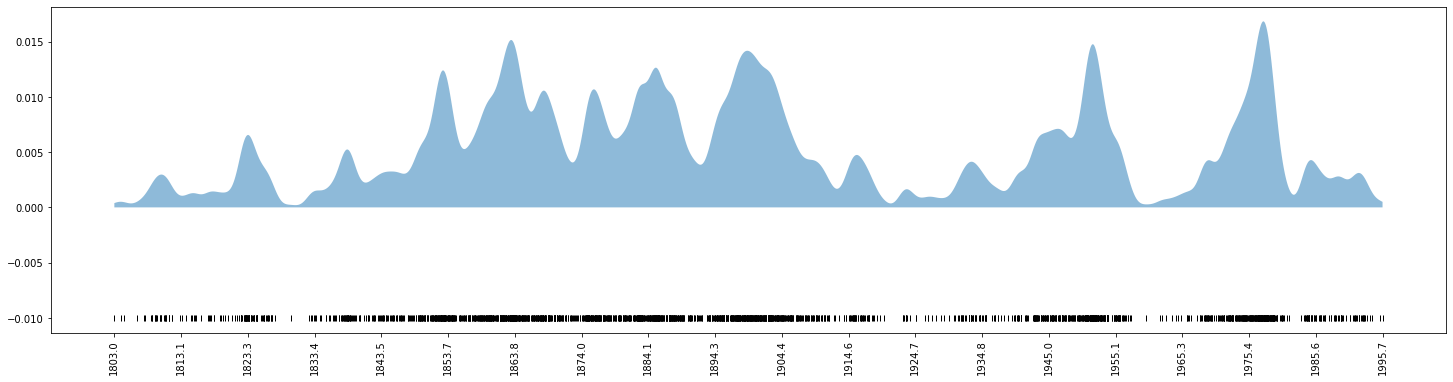

In [118]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

logprob = kde.score_samples(x_d[:, None])

plt.figure(figsize=(25,6))
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
# plt.ylim(-0.02, 0.22)

plt.xticks(x_ticks)
plt.xticks(rotation=90)
